In [2]:
%load_ext autoreload
%autoreload 2

# Load data

In [1]:
import pandas as pd
from spyglass.decoding.v1.waveform_features import (
    UnitWaveformFeatures,
    WaveformFeaturesParams,
)
from spyglass.decoding.v1.clusterless import UnitWaveformFeaturesGroup


from spyglass.spikesorting.spikesorting_merge import SpikeSortingOutput
import numpy as np

import os

cur_dir = os.path.realpath(os.curdir)
cur_dir
# os.chdir("/home/sambray/Documents/MS_analysis_samsplaying")
# from Analysis.utils import filter_opto_data
# from ms_opto_stim_protocol import OptoStimProtocol

os.chdir(cur_dir)
import matplotlib.pyplot as plt

[2025-11-13 16:01:49,905][INFO]: Connecting sambray@lmf-db.cin.ucsf.edu:3306
[2025-11-13 16:01:49,976][INFO]: Connected sambray@lmf-db.cin.ucsf.edu:3306
/home/sambray/mambaforge-pypy3/envs/spyglass2025/lib/python3.10/site-packages/non_local_detector/likelihoods/clusterless_kde.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
# key = {
#     "nwb_file_name": "Winnie20220713_.nwb",
#     "waveform_features_group_name": "10_lineartrack",
# }
key = {
    "nwb_file_name": "Wallie20220912_.nwb",
    "waveform_features_group_name": "10_lineartrack",
}

waveform_keys = (UnitWaveformFeaturesGroup().UnitFeatures & key).fetch("KEY")

times_list, marks_list = (UnitWaveformFeatures & waveform_keys).fetch_data()

/home/sambray/mambaforge-pypy3/envs/spyglass2025/lib/python3.10/site-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.6.0-alpha, loaded version: 2.8.0
ndx-franklab-novela - cached version: 0.1.0, loaded version: 0.2.1
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)
/home/sambray/mambaforge-pypy3/envs/spyglass2025/lib/python3.10/site-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.6.0-alpha, loaded version: 2.8.0
ndx-franklab-novela - cached version: 0.1.0, loaded version: 0.2.1
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please che

In [4]:
mark_times = []
marks = []

n_shanks = len(times_list)

for shank, (t, m) in enumerate(zip(times_list, marks_list)):
    mark_times.extend(t)
    # mark = np.zeros((len(t),m.shape[1],n_shanks))
    # mark[:, :, shank] = m
    # marks.extend(mark)
    mark = np.zeros((len(t), 4 + 1))
    mark[:, : m.shape[1]] = m
    mark[:, -1] = shank
    marks.extend(mark)


marks = np.array(marks)
mark_times = np.array(mark_times)
print(marks.shape, mark_times.shape)

ind = np.argsort(mark_times)
mark_times = mark_times[ind]
marks = marks[ind]

# standardize marks
marks[:, :-1] = (
    marks[:, :-1] - np.mean(marks[:, :-1], axis=1)[:, None]
)  # / np.max(np.abs(marks), axis=1)[
#     :, None, :
# ]
# standardize times
first_mark_time = mark_times[0]
mark_times = mark_times - first_mark_time
# mark_times[mark_times > 10] = 10
mark_times = mark_times * 1000
# print(np.max(np.abs(marks)))
marks[:, :-1] = marks[:, :-1] / 1000  # np.max(np.abs(marks))

(747650, 5) (747650,)


In [6]:
# load position data
key
from spyglass.common import PositionIntervalMap
from spyglass.decoding.v1.core import PositionGroup
from spyglass.position.position_merge import PositionOutput

epoch_key = {
    "nwb_file_name": key["nwb_file_name"],
    "interval_list_name": key["waveform_features_group_name"],
}
pos_interval = (PositionIntervalMap() & epoch_key).fetch1("position_interval_name")

pos_group_key = {
    "nwb_file_name": key["nwb_file_name"],
    "position_group_name": pos_interval,
}
# PositionGroup() & pos_group_key

pos_key = {
    "nwb_file_name": key["nwb_file_name"],
    "interval_list_name": pos_interval,
    "trodes_pos_params_name": "single_led_upsampled",
}
pos_merge_id = (PositionOutput.TrodesPosV1() & pos_key).fetch("merge_id")
pos_merge_key = {"pos_merge_id": pos_merge_id[0]}

from spyglass.linearization.v1 import LinearizedPositionV1

pos_df = (LinearizedPositionV1() & pos_merge_key).fetch1_dataframe()
pos_times = pos_df.index.values - first_mark_time
pos = pos_df.linear_position.values
vel = np.diff(pos_df.linear_position.values)
vel = np.concatenate([vel, [vel[-1]]])
# vel = smooth(vel, 11, 11, hamming=True)


pos_ind = np.digitize(mark_times / 1000, pos_times) - 1
mark_pos = pos[pos_ind]
mark_vel = vel[pos_ind]

/home/sambray/mambaforge-pypy3/envs/spyglass2025/lib/python3.10/site-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.6.0-alpha, loaded version: 2.8.0
ndx-franklab-novela - cached version: 0.1.0, loaded version: 0.2.1
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)


# Prep Data


In [ ]:
import jax
import numpy as np

filter_position = False  # True  # False


# prep data for model
delta_t = np.diff(mark_times)[None, ...]
# delta_t[delta_t >10] = 10
x = marks[1:][None, ...]

ind = np.where(delta_t[0] > 0)[0]
x = x[:, ind]
marks = marks[ind]
mark_times = mark_times[ind]
delta_t = delta_t[:, ind]  # *1000

mark_pos = mark_pos[ind]
mark_vel = mark_vel[ind]


sample_length = 5000  # 2000 v2
i = sample_length
x_train = []
delta_t_train = []
if filter_position:
    valid_pos = np.logical_and(mark_pos > 20, mark_pos < 110)
else:
    valid_pos = np.ones_like(mark_pos).astype(bool)
while i < x.shape[1]:
    if np.any(delta_t[0, i - sample_length : i] > 30000):
        i += np.where(delta_t[0, i - sample_length : i] > 30000)[0][0] + 1
        continue

    if np.mean(valid_pos[i - sample_length : i]) < 0.1:
        i += sample_length // 10
        continue

    x_train.append(x[0, i - sample_length : i])
    delta_t_train.append(delta_t[0, i - sample_length : i])
    i += sample_length // 4


x_train = np.array(x_train)
delta_t_train = np.array(delta_t_train)

print(x_train.shape, delta_t_train.shape)
print(np.mean(np.sum(delta_t_train, axis=1)))

(577, 5000, 5) (577, 5000)
8713.904572111689


# Make the model

In [8]:
from flax.linen import initializers
import os

initializers.lecun_normal()
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
import jax

os.listdir()
# os.chdir('..')
os.chdir("/home/sambray/Documents/c3po/")
from src.c3po.model.model import C3PO

In [ ]:
# define the model
from src.c3po.model.util import prep_training_data

keep_params = 0  # True

if keep_params:
    store_params = params.copy()
# hyperparams
latent_dim = 20
context_dim = 8
n_neg_samples = 2

# encoder
encoder_widths = [16, 32, 64]  # v2[8, 32, 24]
shank_args = dict(encoder_model="simple", widths=encoder_widths)
encoder_args = dict(
    shank_encoder_params=shank_args,
    encoder_model="multi_shank_v1",
    n_shanks=int(marks[:, -1].max()),
)


# context
dilations = [1, 2, 4, 8, 16]
dilations = dilations * 2
kernels = [10, 20, 64, 64, 128]
kernels = kernels * 2
context_args = dict(
    context_model="wavenet",
    layer_dilations=dilations,  # [1, 2, 3, 5, 7, 9, 17, 21, 1, 2, 3, 5, 7, 9, 17, 21],
    layer_kernel_size=kernels,
    expanded_dim=64,
    smoothing=1,
    categorical=False,
)


rate_args = dict(
    rate_model="bilinear",
)

predicted_sequence_length = 1
distribution = "poisson"
sample_params = None  # "gaussian"

model = C3PO(
    encoder_args,
    context_args,
    rate_args,
    distribution,
    latent_dim,
    context_dim,
    n_neg_samples,
    predicted_sequence_length,
    sample_params=sample_params,
    return_embeddings_in_call=True,
)

rand_key = jax.random.PRNGKey(0)
params = model.init(
    jax.random.PRNGKey(1), x_train[:3, :100], delta_t_train[:3, :100], rand_key
)
init_params = params.copy()
# run_model = jax.jit(model.apply)
if keep_params:
    params = store_params.copy()
x_train.shape

x shape (3, 5)


(577, 5000, 5)

# Train model

In [10]:
from src.c3po.model.model import train_model, update_n_neg

params, tracked_loss = train_model(
    model,
    params,
    x_train,
    delta_t_train,
    learning_rate=3e-4,
    n_epochs=1000,
    initial_batch_size=32,  # 64,
    buffer_size=8,
    min_batch_size=4,
    max_n_neg=32,
    initial_n_neg=2,
    # rand_key=jax.random.PRNGKey(42),
)

Epoch 1:   0%|          | 0/577 [00:00<?, ?samples/s]

x shape (32, 5)


Epoch 12:   0%|          | 0/577 [00:00<?, ?samples/s]

x shape (32, 5)


Epoch 20:   0%|          | 0/577 [00:00<?, ?samples/s]

x shape (32, 5)


Epoch 28:   0%|          | 0/577 [00:00<?, ?samples/s]

x shape (32, 5)


Epoch 36:   0%|          | 0/577 [00:00<?, ?samples/s]

x shape (32, 5)


Epoch 43: 100%|█████████▉| 576/577 [00:10<00:00, 55.03samples/s, batch_size=32, loss=3.27, n_neg=32]


Stalled training, decreasing batch size to 16 and n_neg to 4


Epoch 44:   0%|          | 0/577 [00:00<?, ?samples/s]

x shape (16, 5)


Epoch 52:   0%|          | 0/577 [00:00<?, ?samples/s]

x shape (16, 5)


Epoch 60:   0%|          | 0/577 [00:00<?, ?samples/s]

x shape (16, 5)


Epoch 68:   0%|          | 0/577 [00:00<?, ?samples/s]

x shape (16, 5)


Epoch 75: 100%|█████████▉| 576/577 [00:17<00:00, 32.64samples/s, batch_size=16, loss=3.16, n_neg=32]


Stalled training, decreasing batch size to 8 and n_neg to 4


Epoch 76:   0%|          | 0/577 [00:00<?, ?samples/s]

x shape (8, 5)


Epoch 84:   0%|          | 0/577 [00:00<?, ?samples/s]

x shape (8, 5)


Epoch 92:   0%|          | 0/577 [00:00<?, ?samples/s]

x shape (8, 5)


Epoch 100:   0%|          | 0/577 [00:00<?, ?samples/s]

x shape (8, 5)


Epoch 107: 100%|█████████▉| 576/577 [00:31<00:00, 18.53samples/s, batch_size=8, loss=3.02, n_neg=32]


Stalled training, decreasing batch size to 4 and n_neg to 4


Epoch 108:   0%|          | 0/577 [00:00<?, ?samples/s]

x shape (4, 5)


Epoch 116:   0%|          | 0/577 [00:00<?, ?samples/s]

x shape (4, 5)


Epoch 124:   0%|          | 0/577 [00:00<?, ?samples/s]

x shape (4, 5)


Epoch 132:   0%|          | 0/577 [00:00<?, ?samples/s]

x shape (4, 5)


Epoch 139: 100%|█████████▉| 576/577 [00:50<00:00, 11.37samples/s, batch_size=4, loss=2.88, n_neg=32]

Stalled training, no further adjustments possible.


# Store Model

In [11]:
from src.c3po.analysis.analysis import C3poAnalysis

model_args = dict(
    encoder_args=encoder_args,
    context_args=context_args,
    rate_args=rate_args,
    distribution=distribution,
    latent_dim=latent_dim,
    context_dim=context_dim,
    n_neg_samples=n_neg_samples,
    predicted_sequence_length=predicted_sequence_length,
    sample_params=sample_params,
)
analysis = C3poAnalysis(model=model, model_args=model_args, params=params)

In [12]:
analysis.embed_data(x, delta_t, first_mark_time)
analysis.fit_context_pca()

  0%|          | 0/725589 [00:00<?, ?it/s]

x shape (1, 5)


 96%|█████████▋| 700000/725589 [00:06<00:00, 116115.36it/s]


In [15]:
model_name = "rat_hpc_lineartrack_c8z20_model3"

from flax import serialization
from src.c3po.tables.dev_tables import C3POStorage

C3POStorage()
insert_key = {
    "model_name": model_name,
    "encoder_args": encoder_args,
    "context_args": context_args,
    "rate_args": rate_args,
    "latent_dim": latent_dim,
    "context_dim": context_dim,
    "learned_params": serialization.to_bytes(params),
    "input_shape": np.array(x_train.shape[-1]),
}

C3POStorage().insert1(insert_key)
analysis.save_embedding(f"/stelmo/sam/c3po_results/{model_name}_embedding.npz")

In [ ]:
model_name

'rat_hpc_lineartrack_c20z20_model3'

: 

### Quick plot for sanity

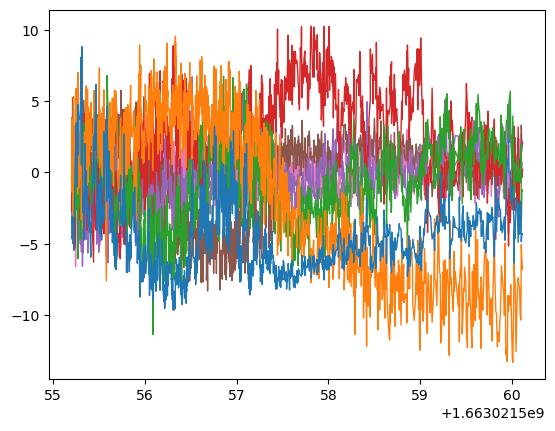

In [14]:
ind = slice(26000, 30000, 3)
for i in range(8):
    plt.plot(analysis.t[ind], analysis.c_pca[ind, i], zorder=-i, lw=1)